# Pipe heat transfer report

## Premise 

The objective of the presented code is to calculate the overall length of a generic vertical pipe needed for reaching saturated conditions.

Pipe main features are:

- Nominal diameter: $D=0.1 \; m$,

- Pipe shell thicknes: $t_k = 0.005 \; m$,

- Pipe absolute roughness: $\epsilon = 0.02 \; mm$

- Pipe solid shell thermal conductivity: $k_s = 20.0 \; W/(m \, K)$,

Therfore, some features can be also derived from previous one:

- Cross section area: $A = \frac{\pi}{4}D^2$,

- Inner radius: $r_1 = D/2$,

- Outer radius: $r_2 = r_1 + t_k$.

Following code lines initialize the presented features and some useful python libraries.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from iapws import IAPWS97

# Pipe parameters
D = 0.1             # [m] pipe diameter
tk = 0.005          # [m] pipe shell thickness
r1 = D/2            # [m] pipe internal radius
r2 = r1 + tk        # [m] pipe outer radius
A = np.pi/4*D**2    # [m^2] pipe cross section area 
eps = 2.*10**(-5)   # [m] pipe wall roughness
ks = 20             # [W/(mK)] pipe solid shell conductivity

Heat is supplied thanks to a constant wall temperature of $T_s = 200 \; °C$. Whereas, the simulated fluid is water flowing upwards within turbulent regime ($Re_{in}=10^{5}$) at atmospheric conditions at the inlet boundary.

These conditions are initialized as follows.

In [16]:
# Boundary conditions
ts = 200.0          # [°C] pipe shell outer temperature

# Inflow conditions
Re_in = 10**5         # inflow Reynolds number
t_in = 20.0           # [°C] inflow temperature
p_in = 10**5          # [Pa] inflow pressure

Using IAPWS97 library, additional flow conditions can be derived.

In [17]:
water_inlet_conditions = IAPWS97(T = t_in+273.15 , P = p_in*10**(-6) )    # water inlet conditions object
i_sat = IAPWS97(P = p_in*10**(-6) , x = 0 ).h*10**3                       # [J/kg] water saturation enthaply at inlet pressure
i_in = water_inlet_conditions.h*10**3                                     # [J/kg] water inlet enthalpy
mu_in = water_inlet_conditions.mu                                         # [Pa s] water inlet dynamic viscosity 
rho_in = water_inlet_conditions.rho                                       # [kg/m^3] water inlet density

G = A*mu_in/D*Re_in                                                       # [kg/s] mass flow rate

print(f'Water saturation enthaply is: {i_sat} [J/kg],')
print(f'Water inlet enthaply is: {i_in} [J/kg],')
print(f'Water mass flow rate is: {G} [kg/s].')

Water saturation enthaply is: 417436.4858162317 [J/kg],
Water inlet enthaply is: 84011.81116713626 [J/kg],
Water mass flow rate is: 7.8665265021701325 [kg/s].


## Heat transfer overall resistance

The idea is to use a finite volume approach to calculate the temperature and enthaply distribution within the pipe using a simple heat power balance equation. The code will continue to add finite volumes of lenght $dL = 0.01 \, m$ until the calculated enthalpy is equal to the saturation enthaply.

<img src="pipe.jpg" alt="Finite Volume" width="300">

In [18]:
# Finite volume length
dL = 0.01       # [m]


In order to do so, it is necessary to implement the definition of the overall thermal resistance/conductivity, taking into account the convective heat transfer within the pipe (in the water side) and the conductive heat transfer within the pipe shell.

Namely, using the electronic equivalence it is possible to define:

- Solid thermal resistance: $R_s = \cfrac{2\pi \, dL \, k_s}{ln(r_2/r_1)}$,

- Fluid thermal resistance: $R_f = 2 \pi r_1 \, dL \, h$,

where $h$ is the convective heat transfer coefficient. It can be estimated from the Dittus–Boelter correlation. Specifically:

$Nu = \cfrac{h \, D}{k} = 0.023Re^{0.8}Pr^{0.4}$,

where:

- $k$ is water conductivity at given temperature and pressure,

- $Re$ is the Reynolds number at given density, viscosity and velocity (which are all dependent from pressure and temperature),

- $Pr$ is the Prandtl number at given viscosity, specific heat and conductivity (all dependent from temperature).

The Dittus–Boelter correlation is valid for circual vertical pipes, filled with fluid flowing along the upwards direction at a Reynolds number higher than or equal to $10^{5}$. Pipe length-to-diameter ratio ($L/D$) must be higher than 50. These limitations are taken from Collier et al. «Convective Boiling and Condensation». The resulting pipe length-to-diameter ratio is verified after the calcultations.

Therefore, the overall thermal conductivity can be calculated as follows:

- $U = \cfrac{1}{\cfrac{1}{R_s}+\cfrac{1}{R_f}} = \cfrac{1}{\cfrac{ln(r_2/r_1)}{2\pi \, dL \, k_s}+\cfrac{1}{2 \pi r_1 \, dL \, h}}$,

it is dependent from water properties at given temperature and pressure. 

Let's write a function that calculates the overall thermal conductivity (and the convective heat transfer coefficient) given water propeties as an object.

In [19]:
# overall thermal resistance
def thermal_resistance(conditions):
    # water properties at found conditions
    rho = conditions.rho                # [kg/m^3] density
    mu = conditions.mu                  # [Pa s] dynamic viscosity
    cp = conditions.cp*10**3            # [J/(kg K)] specific heat capacity
    k = conditions.k                    # [W/(m K)] water conductivity

    v = G/(rho*A)                       # [m/s] average bulk velocity (mass flow is retained)
    Re = D*rho*v/mu                     # Reynolds number for these water conditons
    Pr = mu*cp/k                        # Prandtl number for these water conditons
    Nu = 0.023*Re**0.8*Pr**0.4          # Nusslet number for these water conditons (Dittus–Boelter)
    h = Nu*k/D                          # [W/(m^2 K)] convective heat transfer coefficient

    u = (np.log(r2/r1)/(2*np.pi*ks*dL)+1/(h*2*np.pi*r1*dL))**(-1)    # [W/K] overall thermal resistance

    return u

## Pressure drop implementation

As new volumes are added to the calculation, pressure decreases. In order to estimate the pressure drop along each volume, the Darcy–Weisbach equation is implemented:

- $\Delta p =  f_D \, \cfrac{\rho}{2} \, \cfrac{v^2}{D} \, dL$,

where $f$ can be evaluated using Colebrook correlation:

- $f_D = 4 \, f$ ,

- $\cfrac{1}{\sqrt{f}}=-2\,\log\left( \cfrac{\epsilon}{3.7\,D}+\cfrac{2.51}{Re\sqrt{f}} \right)$.

The Colebrook equation is solved within python thanks to the minimum method: starting with the definition of a range of values of $f$, the absolute difference between the left and right term of the equation is calculated for each value. Then, the value of $f$ which generates the difference closest to zero is stored.

The pressure loss due to velocity changes can be neglected. Whereas, the pressure loss due to gravity can be estimated as follows:

- $\Delta p_g = \rho \, g \, dL$,

which is negative due to the fact that the flow is moving against gravity.

Finally, all remaining quantities can be derived from water properties and mass flow rate.

So, let's write a function that calculates the pressure drop along a finite volume given the water conditions (pressure and temperature).

In [20]:
# function that calculates pressure drop using water conditions at given pressure and temperature
def pressure_drop(conditions):
    # extract water properties
    rho = conditions.rho            # [kg/m^3] density
    mu = conditions.mu              # [Pa s] dynamic viscosity

    v = G/(rho*A)                   # [m/s] average bulk velocity (mass flow is retained)
    Re = D*rho*v/mu                 # Reynolds number for these water conditons

    # calculate pressure drop using Colebrook correlation
    f = np.arange(10**-3, 10, 10**-3)                                               # range of f values
    left_term = np.array([1/(el**0.5) for el in f])                                 # left term of Colebrook correlation
    right_term = np.array([-2*np.log(eps/(3.7*D)+2.51/(Re*el**0.5)) for el in f])   # right term of Colebrook correlation
    min_index = np.argmin(np.absolute(np.array(left_term-right_term)))              # find the index where the difference between the two terms is near 0

    fD = 1/(left_term[min_index]**2)*4                                              # Darcy-Weisbach coefficient calculation
    dp = dL*fD*rho/2*v**2/D                                                         # Darcy-Weisbach pressure drop

    return  dp

## Main loop

The main loop has to solve the heat balance equation. Based on the previous representation of the finite volume, it is possible to write that the thermal power due to the higher temeprarture on the outermost wall surface is equal to the thermal power which couses the increment of the fluid enthalpy. Namely:

$ Q = Q_s = Q_f$,

riminding the explicit formulas:

- $Q_s = U(T_s-T_0) = \cfrac{T_s-T_0}{\cfrac{ln(r_2/r_1)}{2\pi \, dL \, k_s}+\cfrac{1}{2 \pi r_1 \, dL \, h}}  \; \; [W]$

- $Q_f = G (i_1-i_0) \; \; [W]$

Therfore, we can calulate $i_1$, the enthalpy at a length $x+dL$, by combining the previous formulae so that:

$ i_1 = i_0 + \cfrac{U}{G}(T_s-T_0)$,

where $i_0$ and $T_0$ are supposed to be known.

So, starting from inlet conditions (marked with 'in') it is possible to calculate the enthaply while moving along the axial coordinate, adding volumes until saturations conditions are reached.

Additionally, pressure drop is calculated at each step and saturation enthaply is updated according to the new value.

The following lines summarizes what explained so far.

In [21]:
# Solution initialization
i = [i_in]            # [J/kg] water enthalpy
tf = [t_in]           # [°C] water temperature
x = 0                 # [m] pipe overall length
p = [p_in]            # [Pa] pressure

# Iteration loop:
# at each step, it calculates the temperature and the enthalpy at that temperature: 
# if it is still lower than saturation enthaply at that pressure it continues to iterate
# adding a finite volume to the pipe
while i[-1] < i_sat:
    # find water properties for last values of pressure and temperature
    properties = IAPWS97(T = tf[-1]+273.15 , P = p[-1]*10**(-6) )
    # find overall thermal resistance
    U = thermal_resistance(properties)
    # find enthalpy at the next step from balance equation
    i1 = i[-1]+U/G*(ts-tf[-1])
    # find pressure drop
    p1 = p[-1] - pressure_drop(properties) - properties.rho*9.81*dL
    # find temperature at the next step
    t1 = IAPWS97(P = p1*10**-6, h = i1*10**(-3)).T-273.15
    # update saturation enthalpy due to pressure drop
    i_sat = IAPWS97(P = p1*10**(-6) , x = 0 ).h*10**3 
    
    # save values
    i.append(i1)
    tf.append(t1)
    x = x+dL
    p.append(p1)

# relative error from expected value
err = abs((i1-i_sat)/i_sat)*100

# print some results
print(f'Outlet pressure is {p[-1]} Pa')
print(f'Overall pressure drop is: {p_in-p[-1]} Pa,')
print(f'Outlet temperature is {tf[-1]} °C')
print(f'Outlet enthalpy is {i[-1]} J/kg')
print(f'Outlet saturation enthalpy is {i_sat} J/kg')
print(f'Relative error from real saturation enthaply is: {err} % ,')
print(f'Outlet velocity is {G/(properties.rho*A)} m/s')
print(f'Outlet Reynolds is {D*properties.rho/properties.mu*G/(properties.rho*A)} ')
print(f'The length needed to reach saturation is: {x} m.')
print(f'The length-to-diameter raio is: {x/D}.')

def is_valid(l): 
    if l/D > 50:
        return 'valid'
    else:
        return 'not valid'
    
print(f'The Dittus-Boelter correlation is {is_valid(x)}')


Outlet pressure is 10707.540156661646 Pa
Overall pressure drop is: 89292.45984333835 Pa,
Outlet temperature is 47.15111770949534 °C
Outlet enthalpy is 197894.67598106136 J/kg
Outlet saturation enthalpy is 197427.90122995072 J/kg
Relative error from real saturation enthaply is: 0.2364279558272642 % ,
Outlet velocity is 1.0124988470092708 m/s
Outlet Reynolds is 174831.33997472434 
The length needed to reach saturation is: 9.07999999999985 m.
The length-to-diameter raio is: 90.7999999999985.
The Dittus-Boelter correlation is valid


## Main distribution representation 

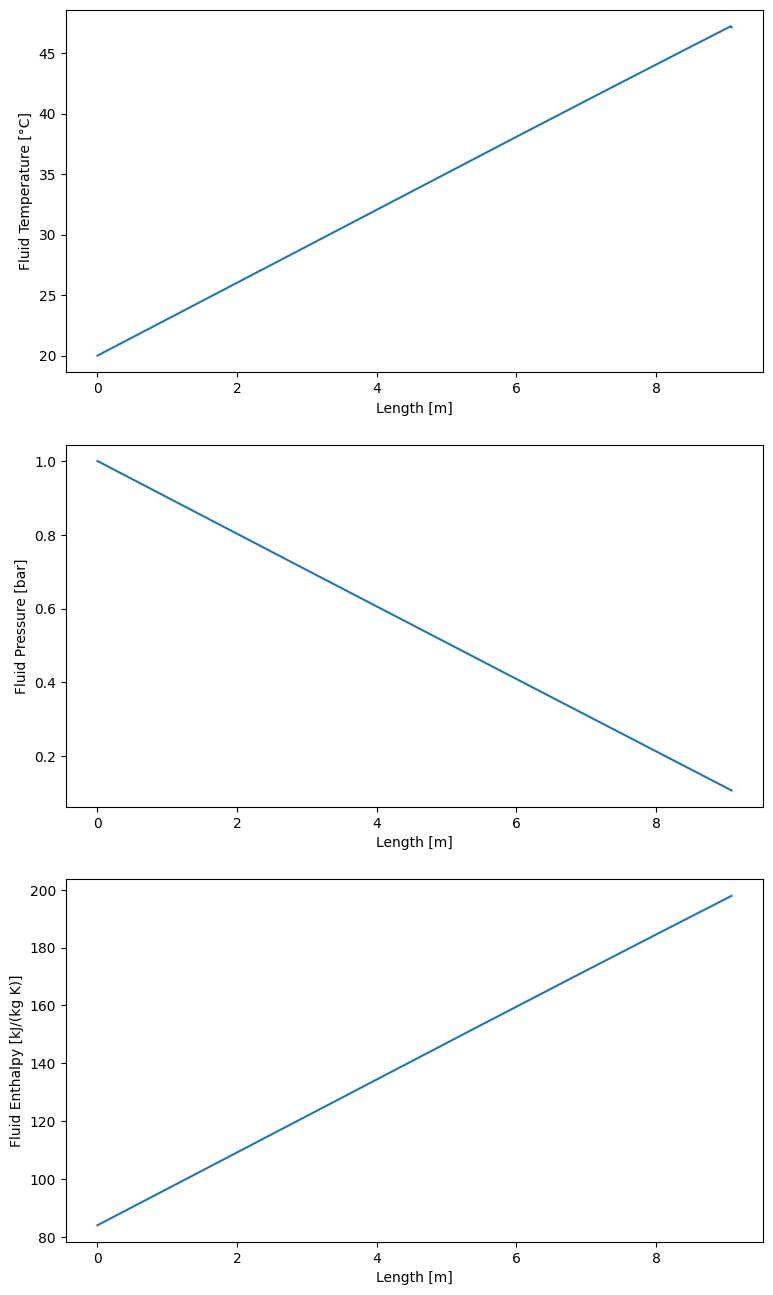

In [22]:
# plot figures
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9, 16))
length = np.linspace(0,x,len(i))


ax1.plot(length,tf,label='Python script')
ax1.set_xlabel('Length [m]')
ax1.set_ylabel('Fluid Temperature [°C]')

ax2.plot(length,np.array(p)*10**-5,label='Python script')
ax2.set_xlabel('Length [m]')
ax2.set_ylabel('Fluid Pressure [bar]')

ax3.plot(length,np.array(i)*10**-3,label='Python script')
ax3.set_xlabel('Length [m]')
ax3.set_ylabel('Fluid Enthalpy [kJ/(kg K)]')

plt.show()

## ATHLET model comparison

The same model and hypothesis were implemented in an ATHLET model of a simple vertical pipe. Lenght however was fixed at $8.0 \, m$. The aim is to verify weather, in these conditions, water within pipe does not reach saturation conditions (since imposed lenght is lower than the one found by previous calculations).

ATHLET results are exported in a .dat file and compared with previous trends.

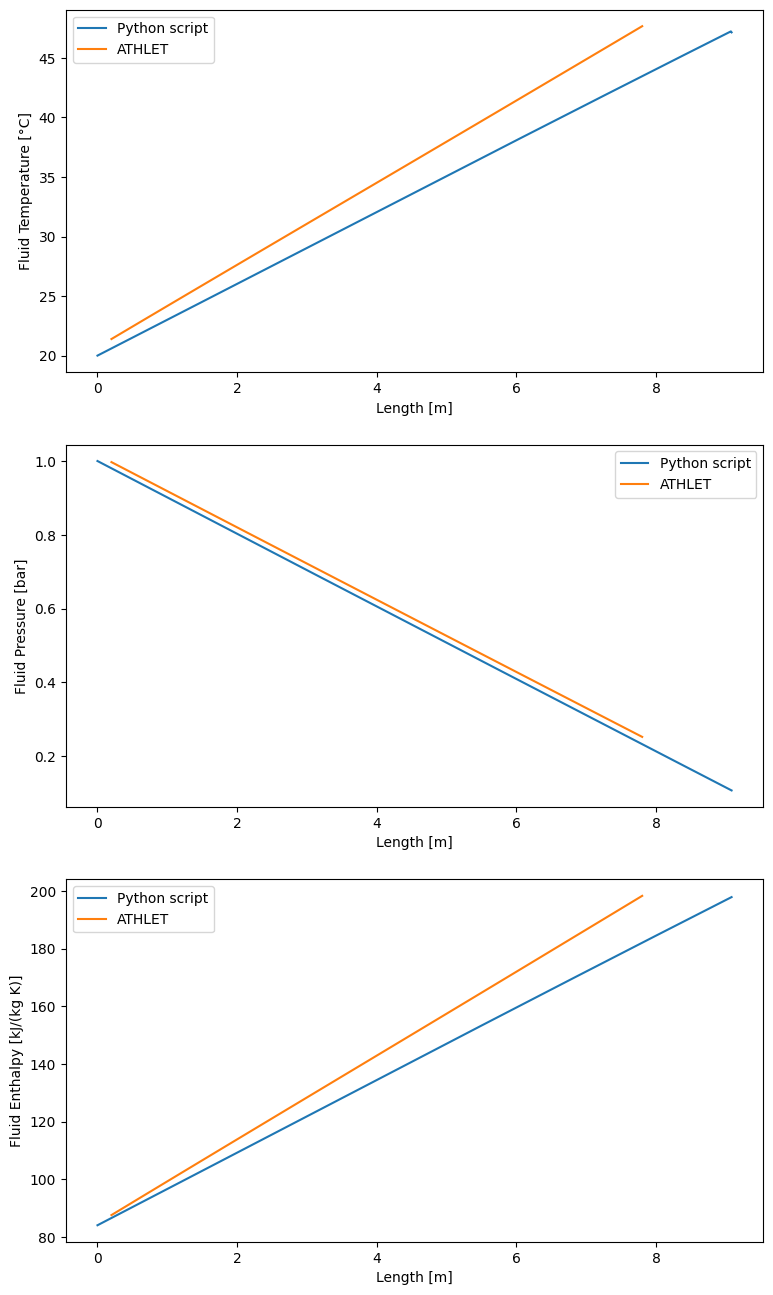

In [25]:
import pandas as pd

# initialize figure
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9, 16))
length = np.linspace(0,x,len(i))

# import ATHLET data
athlet_data = pd.read_csv('athlet_vertical_pipe_results.dat', delimiter=',')

# add new plots
ax1.plot(length,tf,label='Python script')
ax1.set_xlabel('Length [m]')
ax1.set_ylabel('Fluid Temperature [°C]')
ax1.plot(athlet_data['X'],athlet_data['T'],label='ATHLET')
ax1.legend()

ax2.plot(length,np.array(p)*10**-5,label='Python script')
ax2.set_xlabel('Length [m]')
ax2.set_ylabel('Fluid Pressure [bar]')
ax2.plot(athlet_data['X'],athlet_data['P']*10**-5,label='ATHLET')
ax2.legend()

ax3.plot(length,np.array(i)*10**-3,label='Python script')
ax3.set_xlabel('Length [m]')
ax3.set_ylabel('Fluid Enthalpy [kJ/(kg K)]')
ax3.plot(athlet_data['X'],athlet_data['H']*10**-3,label='ATHLET')
ax3.legend()


plt.show()

From previous plots it can be seen that ATHLET temperature distribution is slightly higher than predicted using Dittus–Boelter correlation. This might be due to the different numerical correlation implemented in ATHLET.